In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# installing/upgrading fastai2 
!pip install --upgrade fastai

In [3]:
# installing/upgrading fastai2 
!pip install --upgrade fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.7 MB/s eta 0:00:0000:0100:01m


In [4]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *

In [6]:
#hide_input
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [13]:
??DataBlock

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Source:        
@docs
@funcs_kwargs
class DataBlock():
    "Generic container to quickly build `Datasets` and `DataLoaders`."
    get_x=get_items=splitter=get_y = None
    blocks,dl_type = (TransformBlock,TransformBlock),TfmdDL
    _methods = 'get_items splitter get_y get_x'.split()
    _msg = "If you wanted to compose several transforms in your getter don't forget to wrap them in a `Pipeline`."
    def __init__(self, 
        blocks:list=None, # One or more `TransformBlock`s
        dl_type:TfmdDL=None, # Task specific `TfmdDL`, defaults to `block`'s dl_type or`TfmdDL`
        getters:list=None, # Getter functions applied to results of `get_items`
        n_inp:int=None, # Number of inputs
        item_tfms:list

In [7]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [8]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

In [9]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.539146,1.827906,0.389045,00:21
1,1.969046,30.836842,0.384459,00:20
2,1.658292,1.592710,0.547516,00:20


In [10]:
learn = get_learner(opt_func=SGD)

SuggestedLRs(valley=0.0063095735386013985)

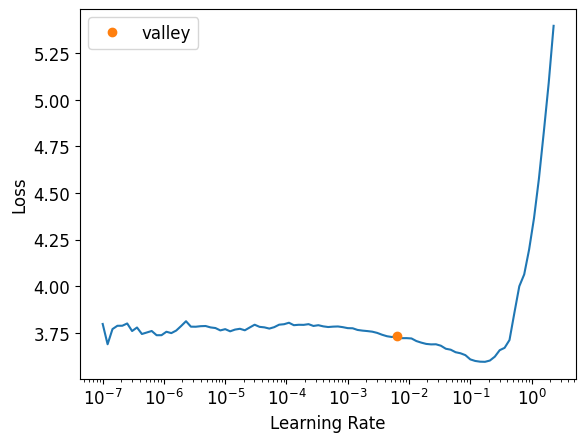

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(3, 0.03, moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,2.926616,2.213527,0.218344,00:19
1,2.274417,1.707887,0.410446,00:18
2,1.960269,1.605665,0.457834,00:19


In [14]:
??learn.fit_one_cycle

Signature:
learn.fit_one_cycle(
    n_epoch,
    lr_max=None,
    div=25.0,
    div_final=100000.0,
    pct_start=0.25,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False, start_epoch=0):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
File:      /opt/conda/lib/python3.10/site-packages/fastai/callback/schedule.py
Type:      met

In [15]:
def zero_grad(self):
    for p,*_ in self.all_params():
        p.grad.detach_()
        p.grad.zero_()

def step(self):
    for p,pg,state,hyper in self.all_params():
        for cb in self.cbs:
            state = _update(state, cb(p, **{**state, **hyper}))
        self.state[p] = state

In [16]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

In [17]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

Great write up on fit_one_cycle vs. fit, and learning rates!

https://iconof.com/1cycle-learning-rate-policy/

In [18]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.683044,1.965284,0.311847,00:18
1,2.208351,1.676327,0.454268,00:18
2,1.925705,1.606531,0.475669,00:18


/tmp/ipykernel_34/553365504.py:1: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1519.)
  def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)
